In [ ]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    brier_score_loss,
    precision_recall_curve,
    auc
)

from imblearn.over_sampling import RandomOverSampler, SMOTE



In [21]:
df = pd.read_csv('Loan_default.csv')
df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0


In [22]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [23]:
print(df.dtypes)
print("\n--- Unique ---\n")
for col in df.columns:
    print(f"{col} ({df[col].dtype}): {df[col].nunique()} unique values")

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

--- Unique ---

LoanID (object): 255347 unique values
Age (int64): 52 unique values
Income (int64): 114620 unique values
LoanAmount (int64): 158729 unique values
CreditScore (int64): 550 unique values
MonthsEmployed (int64): 120 unique values
NumCreditLines (int64): 4 unique values
InterestRate (float64): 2301 unique values
LoanTerm (int64): 5 unique values
DTIRatio (float64): 81 unique values
Education (object): 4 unique values
EmploymentType (object): 4 unique values
MaritalStatus (object): 3 unique values
Has

In [24]:
# 1. Drop the unique identifier column as it won't be used for modeling
df = df.drop(columns=['LoanID'])

# 2. Convert boolean columns with 'Yes'/'No' to numerical 1/0
bool_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
for col in bool_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 3. Apply One-Hot Encoding to categorical columns with multiple categories
cat_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check the result
print(df.head())
print("\nShape of dataframe after processing:", df.shape)


   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   56   85994       50587          520              80               4   
1   69   50432      124440          458              15               1   
2   46   84208      129188          451              26               3   
3   32   31713       44799          743               0               3   
4   60   20437        9139          633               8               4   

   InterestRate  LoanTerm  DTIRatio  HasMortgage  HasDependents  HasCoSigner  \
0         15.23        36      0.44            1              1            1   
1          4.81        60      0.68            0              0            1   
2         21.17        24      0.31            1              1            0   
3          7.07        24      0.23            0              0            0   
4          6.51        48      0.73            0              1            0   

   Default  Education_High School  Education_Master's  Education_PhD

In [25]:
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,HasMortgage,HasDependents,HasCoSigner,Default,Education_High School,Education_Master's,Education_PhD,EmploymentType_Part-time,EmploymentType_Self-employed,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,56,85994,50587,520,80,4,15.23,36,0.44,1,1,1,0,False,False,False,False,False,False,False,False,False,False,False,True
1,69,50432,124440,458,15,1,4.81,60,0.68,0,0,1,0,False,True,False,False,False,False,True,False,False,False,False,True
2,46,84208,129188,451,26,3,21.17,24,0.31,1,1,0,1,False,True,False,False,False,True,False,False,False,False,False,False
3,32,31713,44799,743,0,3,7.07,24,0.23,0,0,0,0,True,False,False,False,False,False,True,False,True,False,False,False
4,60,20437,9139,633,8,4,6.51,48,0.73,0,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False


In [26]:
pd.set_option('display.max_columns', None)
print(df.head())

   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   56   85994       50587          520              80               4   
1   69   50432      124440          458              15               1   
2   46   84208      129188          451              26               3   
3   32   31713       44799          743               0               3   
4   60   20437        9139          633               8               4   

   InterestRate  LoanTerm  DTIRatio  HasMortgage  HasDependents  HasCoSigner  \
0         15.23        36      0.44            1              1            1   
1          4.81        60      0.68            0              0            1   
2         21.17        24      0.31            1              1            0   
3          7.07        24      0.23            0              0            0   
4          6.51        48      0.73            0              1            0   

   Default  Education_High School  Education_Master's  Education_PhD

In [27]:
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [28]:
print(df.dtypes)

Age                               int64
Income                            int64
LoanAmount                        int64
CreditScore                       int64
MonthsEmployed                    int64
NumCreditLines                    int64
InterestRate                    float64
LoanTerm                          int64
DTIRatio                        float64
HasMortgage                       int64
HasDependents                     int64
HasCoSigner                       int64
Default                           int64
Education_High School             int64
Education_Master's                int64
Education_PhD                     int64
EmploymentType_Part-time          int64
EmploymentType_Self-employed      int64
EmploymentType_Unemployed         int64
MaritalStatus_Married             int64
MaritalStatus_Single              int64
LoanPurpose_Business              int64
LoanPurpose_Education             int64
LoanPurpose_Home                  int64
LoanPurpose_Other                 int64


In [29]:
pd.set_option('display.max_columns', None)
print(df.head())

   Age  Income  LoanAmount  CreditScore  MonthsEmployed  NumCreditLines  \
0   56   85994       50587          520              80               4   
1   69   50432      124440          458              15               1   
2   46   84208      129188          451              26               3   
3   32   31713       44799          743               0               3   
4   60   20437        9139          633               8               4   

   InterestRate  LoanTerm  DTIRatio  HasMortgage  HasDependents  HasCoSigner  \
0         15.23        36      0.44            1              1            1   
1          4.81        60      0.68            0              0            1   
2         21.17        24      0.31            1              1            0   
3          7.07        24      0.23            0              0            0   
4          6.51        48      0.73            0              1            0   

   Default  Education_High School  Education_Master's  Education_PhD

In [30]:
df['Default'].value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

In [ ]:

X = df.drop(columns=['Default'])
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.03      0.06      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.50     51070
weighted avg       0.85      0.89      0.84     51070

ROC-AUC: 0.7531085092153331
PR-AUC: 0.3116120667734146


In [ ]:

X = df.drop(columns=['Default'])
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=1),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42, n_jobs=1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42, scale_pos_weight=1)
}


results = []

for name, model in models.items():
    print(f"\n📌 Model trainig: {name}")
    
   
    if name == "CatBoost":
        model.fit(pd.DataFrame(X_train_scaled), y_train_bal)
        y_pred = model.predict(pd.DataFrame(X_test_scaled))
        y_proba = model.predict_proba(pd.DataFrame(X_test_scaled))[:, 1]
    else:
        model.fit(X_train_scaled, y_train_bal)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "PR-AUC": average_precision_score(y_test, y_proba)
    })


results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Recall", ascending=False)
print("\n✅ Compare:")
display(results_df.round(3))



📌 Обучение модели: LogisticRegression

📌 Обучение модели: RandomForest

📌 Обучение модели: LightGBM
[LightGBM] [Info] Number of positive: 180555, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 361110, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📌 Обучение модели: XGBoost


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [09:56:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 Обучение модели: CatBoost

✅ Сравнение моделей:


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC,PR-AUC
0,LogisticRegression,0.677,0.220,0.700,0.335,0.753,0.310
2,LightGBM,0.696,0.228,0.679,0.342,0.757,0.328
3,XGBoost,0.716,0.232,0.626,0.339,0.740,0.308
4,CatBoost,0.728,0.241,0.623,0.347,0.746,0.315
1,RandomForest,0.885,0.559,0.064,0.115,0.739,0.298


In [ ]:


def get_shap_for_logistic(model, X_train, y_train):
    model.fit(X_train, y_train)
    explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_train)
    return shap_values

def get_shap_for_tree_model(model, X_train, y_train, feature_names, model_name, max_shap_samples=10000):
    
    if X_train.shape[0] > max_shap_samples:
        idx = np.random.choice(X_train.shape[0], max_shap_samples, replace=False)
        X_sample = X_train[idx]
    else:
        X_sample = X_train

    if model_name == "CatBoost":
        model.fit(pd.DataFrame(X_train, columns=feature_names), y_train, verbose=0)
        explainer = shap.TreeExplainer(model, approximate=True)
        shap_values = explainer.shap_values(pd.DataFrame(X_sample, columns=feature_names))
    else:
        model.fit(X_train, y_train)
        explainer = shap.TreeExplainer(model, approximate=True)
        shap_values = explainer.shap_values(X_sample)

    return shap_values

def get_top_shap_features(model, X_train, y_train, feature_names, model_name):
    print(f"Train {model_name} and count SHAP...")

    try:
        if model_name == "LogisticRegression":
            shap_values = get_shap_for_logistic(model, X_train, y_train)
        else:
            shap_values = get_shap_for_tree_model(model, X_train, y_train, feature_names, model_name)

        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_values = shap_values[1]

        if shap_values.ndim != 2:
            raise ValueError(f"SHAP values  2D, got: {shap_values.shape}")

        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        shap_importance = pd.Series(mean_abs_shap, index=feature_names)
        shap_importance = shap_importance.sort_values(ascending=False)

        print(f"Top 10 features {model_name}:\n", shap_importance.head(10))
        return list(shap_importance.head(10).index)

    except Exception as e:
        print(f"Error during SHAP calculation {model_name}: {e}")
        print("All will be used.")
        return list(feature_names)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba_test = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba_test = model.decision_function(X_test)
    else:
        y_proba_test = y_pred_test

    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)

    metrics = {
        "Accuracy_train": accuracy_score(y_train, y_pred_train),
        "Accuracy_test": accuracy_score(y_test, y_pred_test),
        "Precision_test": precision_score(y_test, y_pred_test, zero_division=0),
        "Recall_test": recall_score(y_test, y_pred_test, zero_division=0),
        "F1_test": f1_score(y_test, y_pred_test, zero_division=0),
        "ROC-AUC_test": roc_auc_score(y_test, y_proba_test),
        "PR-AUC_test": pr_auc
    }
    return metrics


X = df.drop(columns=['Default'])
y = df['Default']
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(
        class_weight='balanced',
        n_estimators=50,
        max_depth=7,
        max_features='sqrt',
        n_jobs=1,  
        random_state=42
    ),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=1,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        class_weights=[(y_train == 0).sum(), (y_train == 1).sum()],
        verbose=0,
        random_state=42
    )
}

results = []
for name, model in models.items():
    top_features = get_top_shap_features(model, X_train.values, y_train.values, feature_names, name)
    
    model.fit(X_train[top_features], y_train)
    
    metrics = evaluate_model(model, X_train[top_features], y_train, X_test[top_features], y_test)
    
    print(f"Metrics for {name}:\n", metrics)
    results.append({
        "Model": name,
        **metrics
    })

results_df = pd.DataFrame(results)
print("\nCompare models:")
print(results_df)


Обучаем LogisticRegression и считаем SHAP...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Топ 10 фич по SHAP для LogisticRegression:
 InterestRate                 0.409587
Age                          0.403011
MonthsEmployed               0.298077
LoanAmount                   0.287906
Income                       0.220453
NumCreditLines               0.168431
LoanTerm                     0.104869
HasCoSigner                  0.098872
HasDependents                0.095877
EmploymentType_Unemployed    0.092588
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Метрики для LogisticRegression:
 {'Accuracy_train': 0.6738986767967026, 'Accuracy_test': 0.6766007440767574, 'Precision_test': 0.217627914421384, 'Recall_test': 0.6877423705951778, 'F1_test': 0.3306314338980303, 'ROC-AUC_test': np.float64(0.7419321099726468), 'PR-AUC_test': np.float64(0.29157331328537284)}
Обучаем RandomForest и считаем SHAP...
Ошибка при расчете SHAP для RandomForest: SHAP values должны быть 2D, получено: (10000, 24, 2)
Будут использованы все признаки.
Метрики для RandomForest:
 {'Accuracy_train': 0.6891524743363179, 'Accuracy_test': 0.6862541609555513, 'Precision_test': 0.2217381713907577, 'Recall_test': 0.6779632439723486, 'F1_test': 0.3341782671930189, 'ROC-AUC_test': np.float64(0.74815068040136), 'PR-AUC_test': np.float64(0.3122066899504762)}
Обучаем LightGBM и считаем SHAP...
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `f

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Топ 10 фич по SHAP для LightGBM:
 Age                          0.493231
InterestRate                 0.392301
MonthsEmployed               0.284463
Income                       0.237180
LoanAmount                   0.227490
HasCoSigner                  0.113187
HasDependents                0.109686
CreditScore                  0.108007
EmploymentType_Unemployed    0.097961
NumCreditLines               0.087019
dtype: float64
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Метрики для L

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:40:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Топ 10 фич по SHAP для XGBoost:
 Age                          0.549628
InterestRate                 0.434968
MonthsEmployed               0.320810
Income                       0.297966
LoanAmount                   0.268381
CreditScore                  0.140767
HasCoSigner                  0.132922
HasDependents                0.126046
EmploymentType_Unemployed    0.111432
NumCreditLines               0.101438
dtype: float32


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:40:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Метрики для XGBoost:
 {'Accuracy_train': 0.7383895396936513, 'Accuracy_test': 0.7094771881730958, 'Precision_test': 0.2290043816942551, 'Recall_test': 0.6344629910639016, 'F1_test': 0.336538031570004, 'ROC-AUC_test': np.float64(0.7376310751530158), 'PR-AUC_test': np.float64(0.30259520693328573)}
Обучаем CatBoost и считаем SHAP...
Топ 10 фич по SHAP для CatBoost:
 Age                          0.511345
InterestRate                 0.406152
MonthsEmployed               0.300792
Income                       0.246135
LoanAmount                   0.234573
EmploymentType_Unemployed    0.140042
HasCoSigner                  0.132256
HasDependents                0.129491
CreditScore                  0.116907
NumCreditLines               0.098749
dtype: float64
Метрики для CatBoost:
 {'Accuracy_train': 0.8860126201187604, 'Accuracy_test': 0.8843743880947719, 'Precision_test': 0.7096774193548387, 'Recall_test': 0.007418647782835947, 'F1_test': 0.014683797764058067, 'ROC-AUC_test': np.float64(0.752

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 180555, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 361110, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Сравнение моделей:
                Model  Accuracy_train  Accuracy_test  Precision_test  \
0  LogisticRegression        0.672801       0.678108        0.218556   
1            LightGBM        0.699576       0.693480        0.226713   

   Recall_test   F1_test  ROC-AUC_test  PR-AUC_test  
0     0.687911  0.331721      0.742120     0.292211  
1     0.679987  0.340051      0.751127     0.317370  


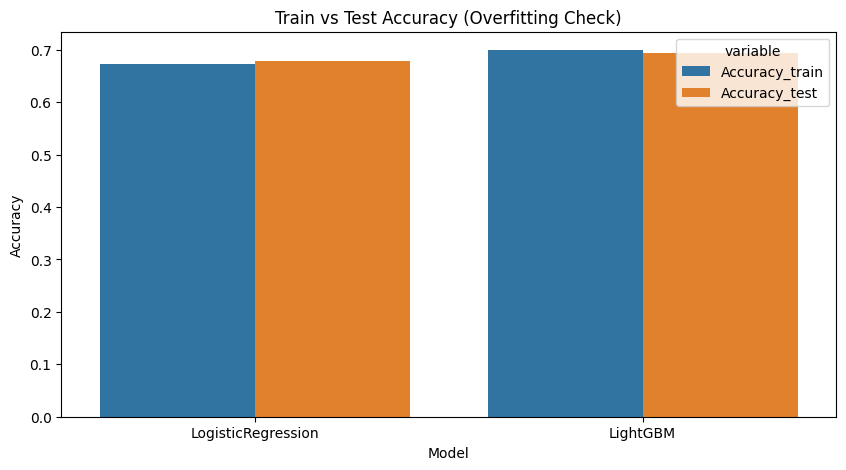

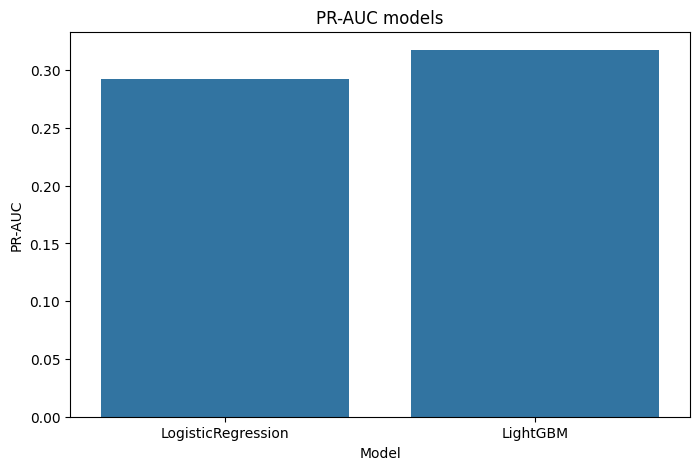

In [ ]:



top_10_features = [
    'Age', 'InterestRate', 'MonthsEmployed', 'LoanAmount', 'Income',
    'NumCreditLines', 'LoanTerm', 'HasCoSigner', 'HasDependents',
    'EmploymentType_Unemployed'
]

# X, y
X = df[top_10_features]
y = df['Default']

# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === 3. Oversampling ===
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)


models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=1, random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', n_jobs=1, random_state=42),
}


def get_model_metrics(model, X_train, y_train, X_test, y_test, name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    return {
        'Model': name,
        'Accuracy_train': accuracy_score(y_train, y_train_pred),
        'Accuracy_test': accuracy_score(y_test, y_test_pred),
        'Precision_test': precision_score(y_test, y_test_pred),
        'Recall_test': recall_score(y_test, y_test_pred),
        'F1_test': f1_score(y_test, y_test_pred),
        'ROC-AUC_test': roc_auc_score(y_test, y_test_proba),
        'PR-AUC_test': average_precision_score(y_test, y_test_proba)
    }


results = []
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    metrics = get_model_metrics(model, X_train_res, y_train_res, X_test, y_test, name)
    results.append(metrics)

metrics_df = pd.DataFrame(results)
print("compare:")
print(metrics_df)




def plot_train_vs_test(metrics_df):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=metrics_df.melt(id_vars='Model', value_vars=['Accuracy_train', 'Accuracy_test']),
                x='Model', y='value', hue='variable')
    plt.title('Train vs Test Accuracy (Overfitting Check)')
    plt.ylabel('Accuracy')
    plt.show()

# PR-AUC
def plot_pr_auc(metrics_df):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=metrics_df, x='Model', y='PR-AUC_test')
    plt.title('PR-AUC models')
    plt.ylabel('PR-AUC')
    plt.show()

plot_train_vs_test(metrics_df)
plot_pr_auc(metrics_df)


In [17]:
from sklearn.model_selection import train_test_split

top_features = [
    'InterestRate',
    'Age',
    'MonthsEmployed',
    'LoanAmount',
    'Income',
    'NumCreditLines',
    'LoanTerm',
    'HasCoSigner',
    'HasDependents',
    'EmploymentType_Unemployed'
]

X_selected = df[top_features]
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (204277, 10), Test shape: (51070, 10)


In [ ]:


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])


param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],
    'logreg__solver': ['saga'],  
    'logreg__l1_ratio': [0, 0.5, 1],  
    'logreg__class_weight': ['balanced', None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=1)
grid_search.fit(X_train, y_train)

print("best:", grid_search.best_params_)
print("Best ROC-AUC :", grid_search.best_score_)

# Оцениваем на тесте
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
y_proba_test = best_model.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
pr_auc = auc(recall, precision)

metrics = {
    "Accuracy_test": accuracy_score(y_test, y_pred_test),
    "Precision_test": precision_score(y_test, y_pred_test, zero_division=0),
    "Recall_test": recall_score(y_test, y_pred_test, zero_division=0),
    "F1_test": f1_score(y_test, y_pred_test, zero_division=0),
    "ROC-AUC_test": roc_auc_score(y_test, y_proba_test),
    "PR-AUC_test": pr_auc
}

print("Metrics on test:", metrics)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle

Лучшие параметры: {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__l1_ratio': 0.5, 'logreg__penalty': 'elasticnet', 'logreg__solver': 'saga'}
Лучший ROC-AUC на кросс-валидации: 0.7391188849542046
Метрики на тесте: {'Accuracy_test': 0.6704719013119248, 'Precision_test': 0.21634565330557, 'Recall_test': 0.7007250042151408, 'F1_test': 0.33061532954138656, 'ROC-AUC_test': np.float64(0.746069112979403), 'PR-AUC_test': np.float64(0.2979596540618478)}


In [ ]:
import pandas as pd


corr_with_target = df.corr()['Default'].abs().sort_values(ascending=False)
print(corr_with_target)

Default                         1.000000
Age                             0.167783
InterestRate                    0.131273
Income                          0.099119
MonthsEmployed                  0.097374
LoanAmount                      0.086659
HasCoSigner                     0.039109
EmploymentType_Unemployed       0.034957
HasDependents                   0.034678
CreditScore                     0.034166
NumCreditLines                  0.028330
MaritalStatus_Married           0.026875
HasMortgage                     0.022856
Education_High School           0.022831
LoanPurpose_Home                0.021564
DTIRatio                        0.019236
Education_PhD                   0.018447
Education_Master's              0.013314
LoanPurpose_Business            0.011162
MaritalStatus_Single            0.006607
EmploymentType_Part-time        0.006372
LoanPurpose_Education           0.003512
LoanPurpose_Other               0.002737
EmploymentType_Self-employed    0.002714
LoanTerm        

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:01:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


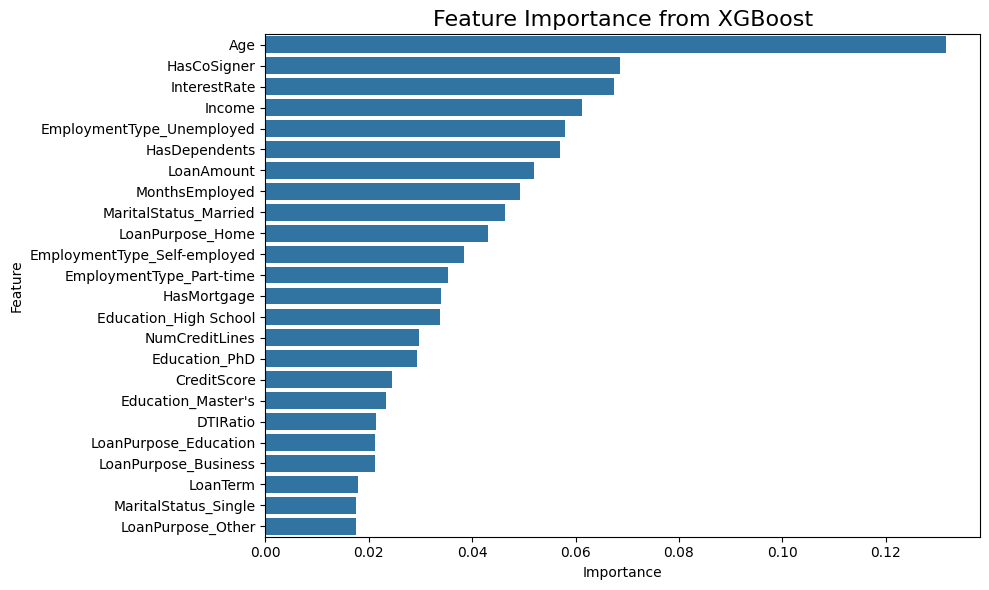

In [ ]:



X = df.drop("Default", axis=1)
y = df["Default"]


model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model.fit(X, y)


importances = model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance from XGBoost", fontsize=16)
plt.tight_layout()
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 29653, number of negative: 225694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 255347, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116128 -> initscore=-2.029617
[LightGBM] [Info] Start training from score -2.029617


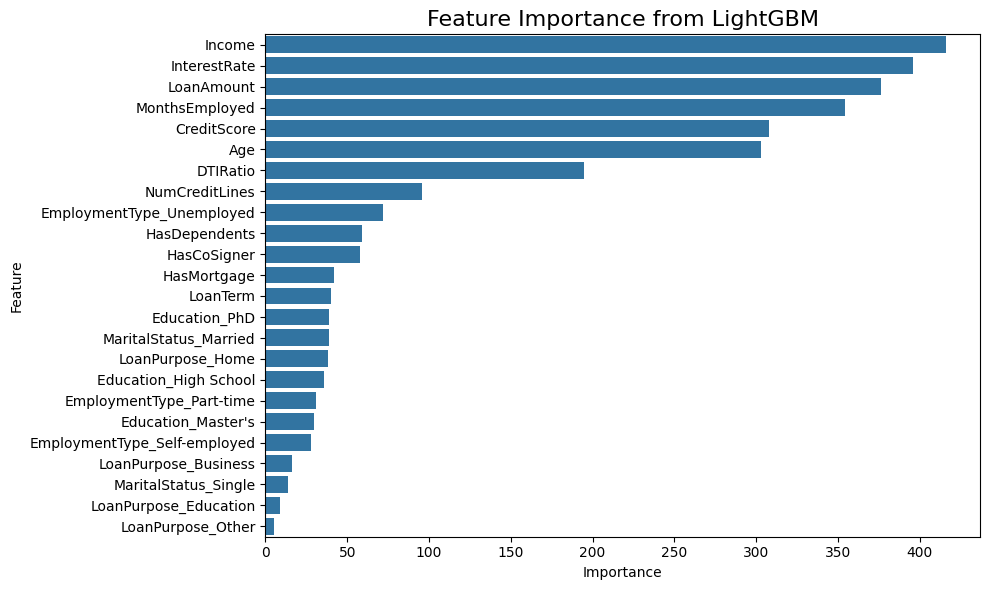

In [ ]:


X = df.drop("Default", axis=1)
y = df["Default"]


model = LGBMClassifier(random_state=42)
model.fit(X, y)


importances = model.feature_importances_
features = X.columns

feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)


plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance from LightGBM", fontsize=16)
plt.tight_layout()
plt.show()


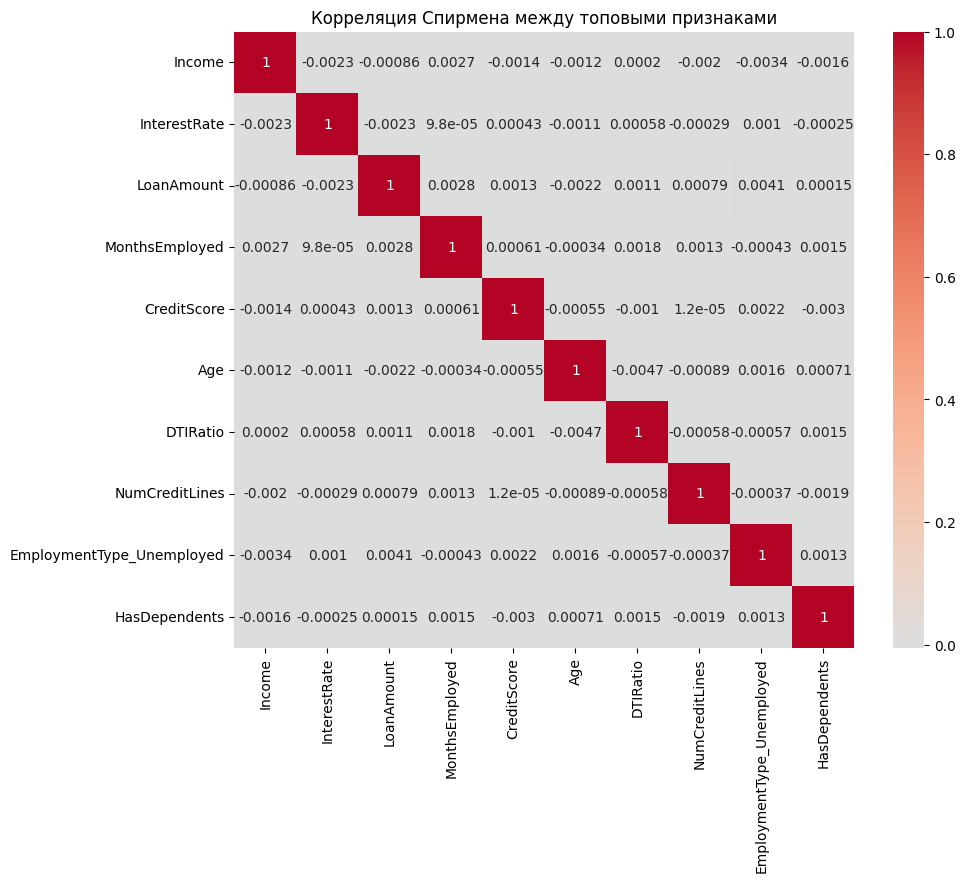

In [ ]:


importances = model.feature_importances_
feature_names = X.columns
top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10).index.tolist()


plt.figure(figsize=(10, 8))
sns.heatmap(X[top_features].corr(method='spearman'), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Top Features (Spearman)", fontsize=16)
plt.show()


In [ ]:



X = df[[
    "Age", "MonthsEmployed", "Income", "HasCoSigner", "HasDependents", 
    "CreditScore", "HasMortgage", "MaritalStatus_Married", 
    "LoanPurpose_Home", "Education_PhD", "Education_Master's"
]]
y = df["Default"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [ ]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [ ]:


logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg_params = {'C': [0.01, 0.1, 1, 10]}

grid_logreg = GridSearchCV(logreg, logreg_params, cv=3, scoring='roc_auc', n_jobs=1)
grid_logreg.fit(X_train_bal, y_train_bal)

best_logreg = grid_logreg.best_estimator_
y_pred = best_logreg.predict(X_test_scaled)
print("Best params:", grid_logreg.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC (train):", roc_auc_score(y_train, best_logreg.predict_proba(X_train_scaled)[:, 1]))
print("ROC AUC (test):", roc_auc_score(y_test, best_logreg.predict_proba(X_test_scaled)[:, 1]))


Best params: {'C': 0.01}
              precision    recall  f1-score   support

           0       0.94      0.64      0.76     56424
           1       0.20      0.67      0.31      7413

    accuracy                           0.64     63837
   macro avg       0.57      0.66      0.53     63837
weighted avg       0.85      0.64      0.71     63837

ROC AUC (train): 0.7019275694231641
ROC AUC (test): 0.7114106268950269


In [ ]:


rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=1)
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}

grid_rf = GridSearchCV(rf, rf_params, cv=3, scoring='roc_auc', n_jobs=1)
grid_rf.fit(X_train_bal, y_train_bal)

best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test_scaled)
print("Best params:", grid_rf.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC (train):", roc_auc_score(y_train, best_rf.predict_proba(X_train_scaled)[:, 1]))
print("ROC AUC (test):", roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:, 1]))


Best params: {'max_depth': None, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     56424
           1       0.23      0.26      0.24      7413

    accuracy                           0.81     63837
   macro avg       0.57      0.57      0.57     63837
weighted avg       0.82      0.81      0.82     63837

ROC AUC (train): 1.0
ROC AUC (test): 0.6620831419024702


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112846, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 225693, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 112847, number of negative: 112847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 225694, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 169270, number of negative: 169270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1082
[LightGBM] [Info] Number of data points in the train set: 338540, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best params: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     56424
           1       0.37      0.11      0.17      7413

    accuracy                           0.88     63837
   macro avg       0.63      0.54      0.55     63837
weighted avg       0.83      0.88      0.84     63837



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC AUC (train): 0.696256539666949


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC AUC (test): 0.697245679017871


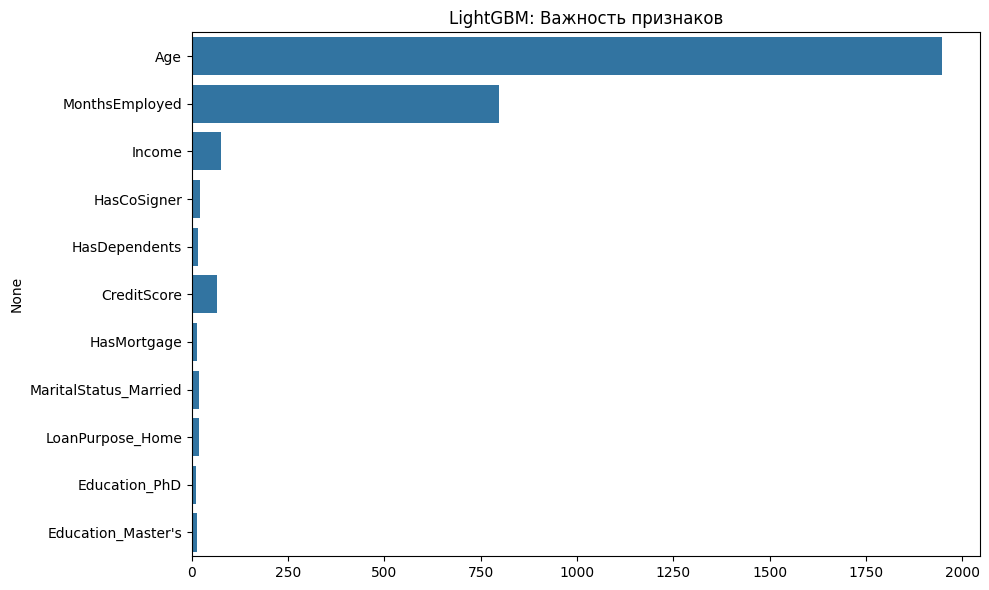

In [ ]:


lgb = LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=1)
lgb_params = {
    'num_leaves': [15, 31],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100]
}

grid_lgb = GridSearchCV(lgb, lgb_params, scoring='roc_auc', cv=3, n_jobs=1)
grid_lgb.fit(X_train_bal, y_train_bal)

best_lgb = grid_lgb.best_estimator_
y_pred = best_lgb.predict(X_test_scaled)
print("Best params:", grid_lgb.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC (train):", roc_auc_score(y_train, best_lgb.predict_proba(X_train_scaled)[:, 1]))
print("ROC AUC (test):", roc_auc_score(y_test, best_lgb.predict_proba(X_test_scaled)[:, 1]))




In [ ]:


xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=1)
xgb_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 5]
}

grid_xgb = GridSearchCV(xgb, xgb_params, scoring='roc_auc', cv=3, n_jobs=1)
grid_xgb.fit(X_train_bal, y_train_bal)

best_xgb = grid_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
print("Best params:", grid_xgb.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC (train):", roc_auc_score(y_train, best_xgb.predict_proba(X_train_scaled)[:, 1]))
print("ROC AUC (test):", roc_auc_score(y_test, best_xgb.predict_proba(X_test_scaled)[:, 1]))


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:20:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:20:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:20:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:20:16] WARN

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     56424
           1       0.23      0.46      0.30      7413

    accuracy                           0.76     63837
   macro avg       0.57      0.63      0.58     63837
weighted avg       0.84      0.76      0.79     63837

ROC AUC (train): 0.6955701077319747
ROC AUC (test): 0.6908927982576047


In [ ]:


cat = CatBoostClassifier(verbose=0, random_state=42)
cat_params = {
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'iterations': [100, 200]
}

grid_cat = GridSearchCV(cat, cat_params, scoring='roc_auc', cv=3, n_jobs=1)
grid_cat.fit(X_train_bal, y_train_bal)

best_cat = grid_cat.best_estimator_
y_pred = best_cat.predict(X_test_scaled)
print("Best params:", grid_cat.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC (train):", roc_auc_score(y_train, best_cat.predict_proba(X_train_scaled)[:, 1]))
print("ROC AUC (test):", roc_auc_score(y_test, best_cat.predict_proba(X_test_scaled)[:, 1]))


Best params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     56424
           1       0.47      0.03      0.05      7413

    accuracy                           0.88     63837
   macro avg       0.68      0.51      0.49     63837
weighted avg       0.84      0.88      0.83     63837

ROC AUC (train): 0.7052450025564708
ROC AUC (test): 0.7087867999834518


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029633
[LightGBM] [Info] Start training from score -2.029633


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


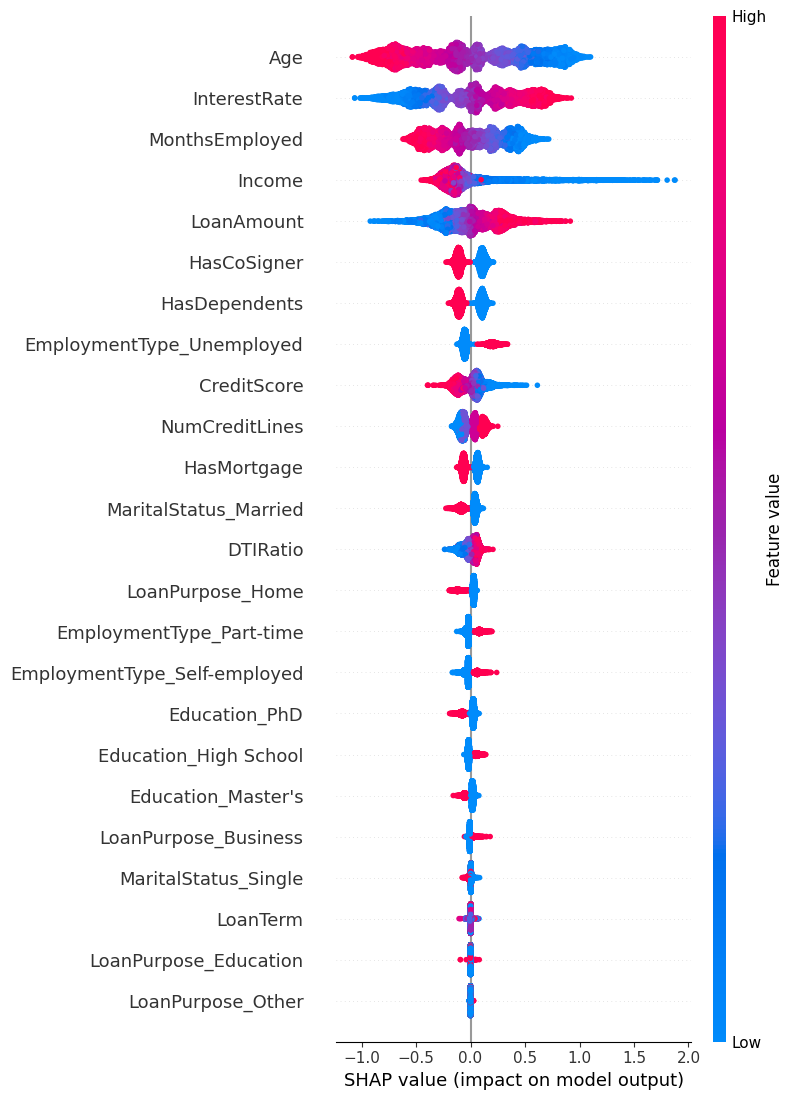

In [ ]:


features = df.drop(columns=['Default'])

X = features
y = df['Default']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)


sample_size = min(10000, len(X_train))
sample_idx = np.random.choice(X_train.index, size=sample_size, replace=False)
X_sample = X_train.loc[sample_idx]


explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_sample)


shap.summary_plot(shap_values, X_sample, max_display=30)


In [ ]:



selected_features = [
    "Age", "MonthsEmployed", "Income", "HasCoSigner", "HasDependents",
    "CreditScore", "HasMortgage", "MaritalStatus_Married",
    "LoanPurpose_Home", "Education_PhD", "Education_Master's"
]

X = df[selected_features]
y = df['Default']

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.88      1.00      0.94     45139
           1       0.58      0.00      0.00      5931

    accuracy                           0.88     51070
   macro avg       0.73      0.50      0.47     51070
weighted avg       0.85      0.88      0.83     51070

ROC AUC: 0.711445063738356


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report


y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:,1]


y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:,1]

print("Train classification report:")
print(classification_report(y_train, y_train_pred))
print("Train ROC AUC:", roc_auc_score(y_train, y_train_proba))

print("\nTest classification report:")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))


Train classification report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    180555
           1       0.57      0.00      0.00     23722

    accuracy                           0.88    204277
   macro avg       0.73      0.50      0.47    204277
weighted avg       0.85      0.88      0.83    204277

Train ROC AUC: 0.7025448912168398

Test classification report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     45139
           1       0.58      0.00      0.00      5931

    accuracy                           0.88     51070
   macro avg       0.73      0.50      0.47     51070
weighted avg       0.85      0.88      0.83     51070

Test ROC AUC: 0.711445063738356


[LightGBM] [Info] Number of positive: 18978, number of negative: 144444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 163422, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116129 -> initscore=-2.029611
[LightGBM] [Info] Start training from score -2.029611


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


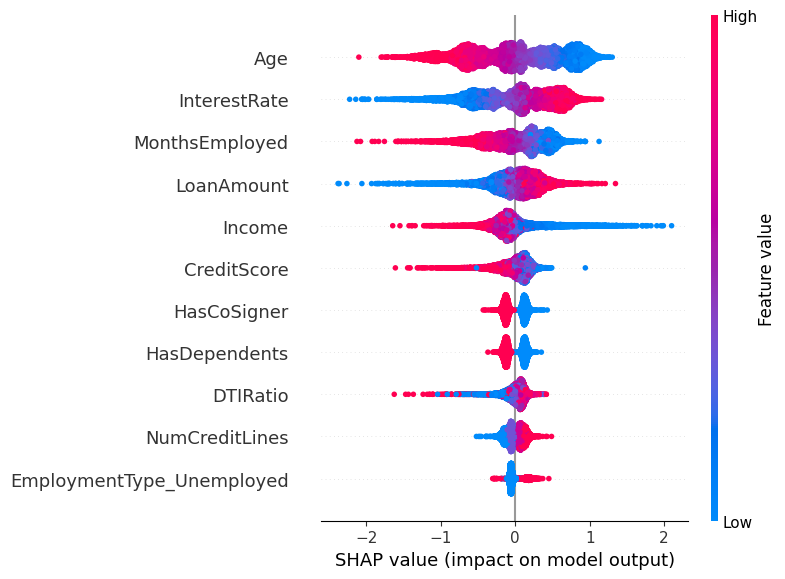

In [ ]:



sample_idx = np.random.choice(X_train.index, size=10000, replace=False)
X_sample = X_train.loc[sample_idx]


lgbm.fit(X_train, y_train)


explainer = shap.TreeExplainer(lgbm)


shap_values = explainer.shap_values(X_sample)


shap.summary_plot(shap_values, X_sample)


In [ ]:



top_n = 10
top_features = feature_importance_df['Feature'].iloc[:top_n].tolist()
print(f"Top {top_n} features:", top_features)


X_top = X[top_features]


X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)


y_pred  = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Top 10 features: ['Income', 'InterestRate', 'LoanAmount', 'MonthsEmployed', 'CreditScore', 'Age', 'DTIRatio', 'NumCreditLines', 'EmploymentType_Unemployed', 'HasDependents']

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.02      0.05      5931

    accuracy                           0.88     51070
   macro avg       0.75      0.51      0.49     51070
weighted avg       0.85      0.88      0.84     51070

ROC AUC: 0.7447713437915142


In [ ]:


features = [
    "Age", "MonthsEmployed", "Income", "HasCoSigner", "HasDependents", 
    "CreditScore", "HasMortgage", "MaritalStatus_Married", 
    "LoanPurpose_Home", "Education_PhD", "Education_Master's"
]

X = df[features]
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    lambda_l1=1.0,
    lambda_l2=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

threshold = 0.35


y_train_proba = lgbm.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba > threshold).astype(int)
print("=== TRAIN METRICS ===")
print(classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Train PR AUC: {average_precision_score(y_train, y_train_proba):.4f}")


y_test_proba = lgbm.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > threshold).astype(int)
print("\n=== TEST METRICS ===")
print(classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Test PR AUC: {average_precision_score(y_test, y_test_proba):.4f}")


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029633
[LightGBM] [Info] Start training from score -2.029633
[LightGBM] [Warning] No fur

In [ ]:



sample_size = int(len(X_train) * 0.3)
sample_idx = np.random.choice(X_train.index, size=sample_size, replace=False)
X_train_sample = X_train.loc[sample_idx]
y_train_sample = y_train.loc[sample_idx]

param_dist = {
    'num_leaves': [20, 31, 50, 70],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

lgbm = LGBMClassifier(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=10,          
    scoring='roc_auc',   
    cv=3,                # 3-fold cv
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_sample, y_train_sample)

print("Best paremetrs:", random_search.best_params_)
print(f"Best ROC AUC cross-validation : {random_search.best_score_:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4137, number of negative: 31611
[LightGBM] [Info] Number of positive: 4137, number of negative: 31611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of positive: 4138, number of negative: 31610
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 35748, number of used features: 24
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006708 seconds.
You can set `for

In [ ]:


lgbm_final = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.6,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)


lgbm_final.fit(X_train, y_train)


y_train_pred_proba = lgbm_final.predict_proba(X_train)[:, 1]
y_test_pred_proba = lgbm_final.predict_proba(X_test)[:, 1]


print(classification_report(y_train, y_train_pred_proba > 0.35))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print(f"Train PR AUC: {average_precision_score(y_train, y_train_pred_proba):.4f}")

print("\n=== TEST METRICS ===")
print(classification_report(y_test, y_test_pred_proba > 0.35))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"Test PR AUC: {average_precision_score(y_test, y_test_pred_proba):.4f}")


roc_diff = roc_auc_score(y_train, y_train_pred_proba) - roc_auc_score(y_test, y_test_pred_proba)
pr_diff = average_precision_score(y_train, y_train_pred_proba) - average_precision_score(y_test, y_test_pred_proba)
print(f"\nROC AUC difference (train - test): {roc_diff:.4f}")
print(f"PR AUC difference (train - test): {pr_diff:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20757, number of negative: 157985
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 178742, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116128 -> initscore=-2.029617
[LightGBM] [Info] Start training from score -2.029617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:


# RandomizedSearch
lgbm_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
}

# model and RandomizedSearchCV
lgbm_model = LGBMClassifier(random_state=42)

lgbm_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgbm_params,
    n_iter=5,
    cv=2,
    scoring='roc_auc',
    verbose=2,
    random_state=42,
    n_jobs=1  
)


lgbm_search.fit(X_train_scaled, y_train)


model = lgbm_search.best_estimator_
print("Best LGBM params:", lgbm_search.best_params_)


y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

print("\n=== TRAIN Classification Report ===")
print(classification_report(y_train, y_train_pred))
print("Train ROC AUC:", roc_auc_score(y_train, y_train_proba))
print("Train Brier Score:", brier_score_loss(y_train, y_train_proba))


y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\n=== TEST Classification Report ===")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("Test Brier Score:", brier_score_loss(y_test, y_test_proba))


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 11861, number of negative: 90277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102138, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029627
[LightGBM] [Info] Start training from score -2.029627


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=50; total time=   1.6s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102139, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116126 -> initscore=-2.029638
[LightGBM] [Info] Start training from score -2.029638


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.05, max_depth=10, n_estimators=100, num_leaves=50; total time=   1.7s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102138, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029627
[LightGBM] [Info] Start training from score -2.029627


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=50; total time=   1.3s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102139, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116126 -> initscore=-2.029638
[LightGBM] [Info] Start training from score -2.029638


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=50; total time=   1.4s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102138, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029627
[LightGBM] [Info] Start training from score -2.029627


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31; total time=   1.0s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102139, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116126 -> initscore=-2.029638
[LightGBM] [Info] Start training from score -2.029638


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31; total time=   1.1s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102138, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029627
[LightGBM] [Info] Start training from score -2.029627


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31; total time=   1.2s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102139, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116126 -> initscore=-2.029638
[LightGBM] [Info] Start training from score -2.029638


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31; total time=   1.2s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102138, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029627
[LightGBM] [Info] Start training from score -2.029627


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=20, n_estimators=100, num_leaves=100; total time=   2.3s
[LightGBM] [Info] Number of positive: 11861, number of negative: 90278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 102139, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116126 -> initscore=-2.029638
[LightGBM] [Info] Start training from score -2.029638


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END learning_rate=0.1, max_depth=20, n_estimators=100, num_leaves=100; total time=   2.1s
[LightGBM] [Info] Number of positive: 23722, number of negative: 180555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116127 -> initscore=-2.029633
[LightGBM] [Info] Start training from score -2.029633
Best LGBM params: {'num_leaves': 50, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05}


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== TRAIN Classification Report ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94    180555
           1       0.69      0.06      0.11     23722

    accuracy                           0.89    204277
   macro avg       0.79      0.53      0.52    204277
weighted avg       0.87      0.89      0.84    204277

Train ROC AUC: 0.7717838557206391
Train Brier Score: 0.08943244288950469


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== TEST Classification Report ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.05      0.09      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.52     51070
weighted avg       0.86      0.89      0.84     51070

Test ROC AUC: 0.7500758564725503
Test Brier Score: 0.09171904892393759


In [38]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [catboost]3/4 [catboost]
Note: you may need to restart the kernel to use updated packages.


In [ ]:



cat_params = {
    'iterations': [100, 200],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

cat = CatBoostClassifier(verbose=0, random_state=42)

cat_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_params,
    n_iter=5,
    cv=2,
    scoring='roc_auc',
    random_state=42,
    n_jobs=1
)

cat_search.fit(X_train_scaled, y_train)

best_cat = cat_search.best_estimator_
print("Best CatBoost params:", cat_search.best_params_)


y_train_pred = best_cat.predict(X_train_scaled)
y_test_pred = best_cat.predict(X_test_scaled)
y_train_proba = best_cat.predict_proba(X_train_scaled)[:, 1]
y_test_proba = best_cat.predict_proba(X_test_scaled)[:, 1]


print("\n=== TRAIN ===")
print(classification_report(y_train, y_train_pred))
print("Train ROC AUC:", roc_auc_score(y_train, y_train_proba))
print("Train Brier Score:", brier_score_loss(y_train, y_train_proba))

print("\n=== TEST ===")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("Test Brier Score:", brier_score_loss(y_test, y_test_proba))

Best CatBoost params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 100, 'depth': 6}

=== TRAIN ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94    180555
           1       0.63      0.06      0.11     23722

    accuracy                           0.89    204277
   macro avg       0.76      0.53      0.53    204277
weighted avg       0.86      0.89      0.84    204277

Train ROC AUC: 0.7540308395477844
Train Brier Score: 0.09118952422961812

=== TEST ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.06      0.11      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.53      0.52     51070
weighted avg       0.86      0.89      0.84     51070

Test ROC AUC: 0.752542633171583
Test Brier Score: 0.09134144871688536


In [ ]:

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_proba = rf.predict_proba(X_train)[:, 1]

y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

print("=== RANDOM FOREST TRAIN METRICS ===")
print(classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Train PR AUC: {average_precision_score(y_train, y_train_proba):.4f}")

print("\n=== RANDOM FOREST TEST METRICS ===")
print(classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Test PR AUC: {average_precision_score(y_test, y_test_proba):.4f}")


=== RANDOM FOREST TRAIN METRICS ===
              precision    recall  f1-score   support

           0       0.94      0.69      0.80    180555
           1       0.22      0.67      0.33     23722

    accuracy                           0.69    204277
   macro avg       0.58      0.68      0.57    204277
weighted avg       0.86      0.69      0.74    204277

Train ROC AUC: 0.7476
Train PR AUC: 0.3106

=== RANDOM FOREST TEST METRICS ===
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     45139
           1       0.22      0.67      0.33      5931

    accuracy                           0.69     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.69      0.74     51070

Test ROC AUC: 0.7449
Test PR AUC: 0.3068


In [40]:

selected_features = ['Age', 'Income', 'LoanAmount']
X = df[selected_features]
y = df['Default']  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)


pickle.dump(model, open("model.pkl", "wb"))
pickle.dump(selected_features, open("features.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
